# Learning Curve Forecasting with Meta-Learning GP

This notebook demonstrates how to use the `LearningCurveForecaster` to predict the future performance of a model given a short history of training loss.

### Strategy
1.  **Meta-Learning**: We use a set of **historical learning curves** to learn the "typical" behavior (kernel hyperparameters) of your models.
2.  **Forecasting**: We use these learned priors to constrain the forecast on a **new, partially observed curve**, stabilizing predictions even with very few data points.

### Requirements
Ensure `model.py` is in the same directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from model import LearningCurveForecaster

# Settings for visualization
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [2]:
# --- User Configuration ---
# Adjustable parameters for your use case

# 1. Data Generation (Replace with your data loading logic if needed)
N_HISTORY_CURVES = 50        # How many past experiments we have
N_FORECAST_SAMPLES = 3       # How many new curves to test
OBSERVATION_COUNT = 6        # How many initial steps we see for the new curves

# 2. Simulation Params (Power Law: y = a*x^-b + c)
TRAIN_STEPS = np.unique(np.geomspace(10, 1000, 20).astype(int))
FUTURE_STEPS = np.linspace(10, 3000, 300)

In [3]:
def simulate_curve(steps, a_range=(1.0, 5.0), b_range=(0.3, 0.5), c_range=(0.01, 0.1)):
    """
    Helper to generate synthetic learning curves.
    Replace this with your own data loading function!
    """
    a = np.random.uniform(*a_range)
    b = np.random.uniform(*b_range)
    c = np.random.uniform(*c_range)
    
    clean = a * (steps**-b) + c
    noise = np.random.normal(0, 0.05 * clean) # 2% relative noise
    return clean + noise

print("Simulation helper defined.")

Simulation helper defined.


## 1. Meta-Training
We fit Gaussian Processes to all your historical curves. The goal is not to predict them (they are already done), but to **extract their hyperparameters** (Length scales, amplitudes).

In [4]:
print(f"Processing {N_HISTORY_CURVES} historical curves...")
hist_thetas = []

for i in range(N_HISTORY_CURVES):
    # Simulate a historical curve (replace with real data loading)
    losses = simulate_curve(TRAIN_STEPS)
    
    # Fit GP
    forecaster = LearningCurveForecaster()
    try:
        forecaster.fit(TRAIN_STEPS, losses)
        # Save the learned log-hyperparameters
        hist_thetas.append(forecaster.model.kernel_.theta)
    except Exception as e:
        # Occasional convergence failures can happen with random data
        pass

if not hist_thetas:
    raise RuntimeError("No models converged. Check data scaling or initial usage.")

# Compute the "Bachelor's Prior" - the average hyperparameters
avg_theta = np.mean(hist_thetas, axis=0)
print(f"\nLearned Average Hyperparameters (Theta):\n{avg_theta}")

# Construct the Best Kernel
dummy = LearningCurveForecaster()
best_kernel = dummy.model.kernel.clone_with_theta(avg_theta)
print(f"\nMeta-Learned Kernel:\n{best_kernel}")

Processing 50 historical curves...


/Users/kyunghyuncho/Repos/curve-predictor/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 14 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



Learned Average Hyperparameters (Theta):
[ 2.39434798  3.3253892  -6.17833758]

Meta-Learned Kernel:
3.31**2 * Matern(length_scale=27.8, nu=1.5) + WhiteKernel(noise_level=0.00207)


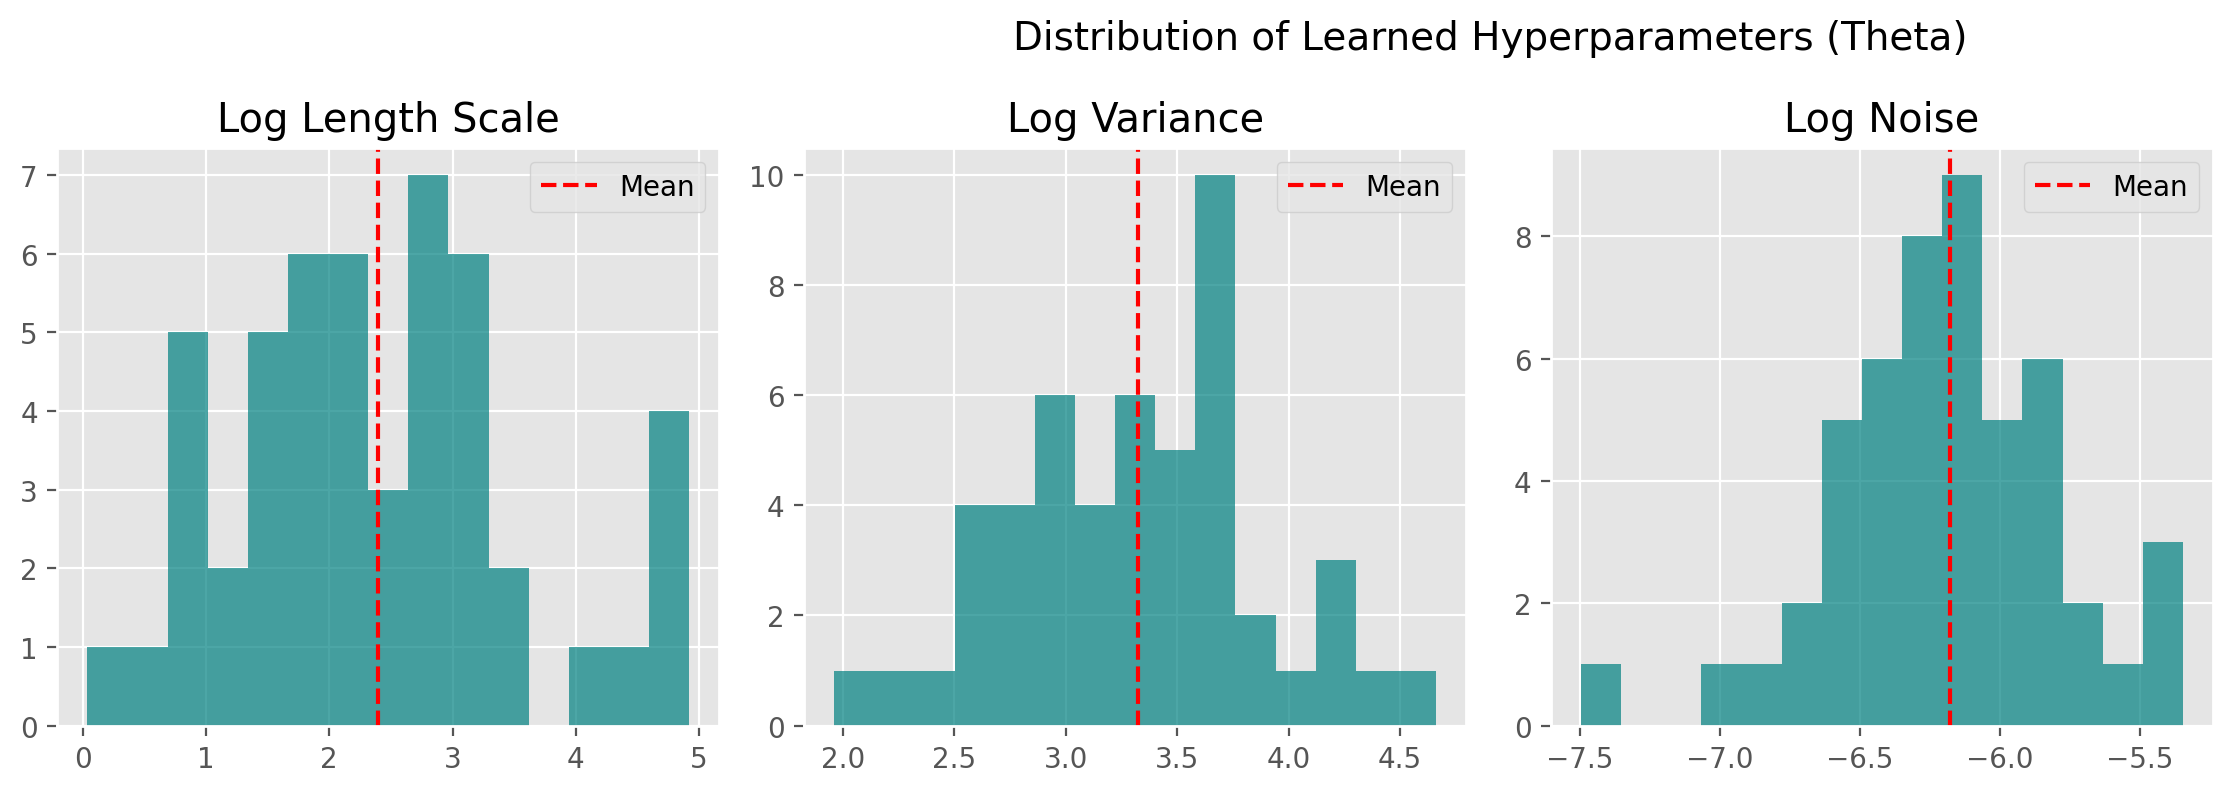

In [7]:
# --- Verify Hyperparameter Distribution ---
# It is important to check if the historical curves form a single cluster.
# If the histograms are multi-modal (two peaks), simplistic averaging might fail.

hist_thetas_np = np.array(hist_thetas)
param_names = ["Log Length Scale", "Log Variance", "Log Noise"] # Simplified labels

plt.figure(figsize=(15, 4))
for i in range(hist_thetas_np.shape[1]):
    plt.subplot(1, 4, i+1)
    
    # Handle cases where kernel structure might vary slightly (just a safety check)
    if i < len(param_names):
        name = param_names[i]
    else:
        name = f"Param {i}"
        
    plt.hist(hist_thetas_np[:, i], bins=15, color='teal', alpha=0.7)
    plt.axvline(avg_theta[i], color='red', linestyle='--', label='Mean')
    plt.title(f"{name}")
    plt.legend()
    
plt.suptitle("Distribution of Learned Hyperparameters (Theta)", fontsize=14)
plt.tight_layout()
plt.show()

## 2. Forecasting
Now we take new curves, observe only the first `OBSERVATION_COUNT` steps, and predict the rest. 
We compare two approaches:
*   **Baseline**: Fits parameters from scratch (can be unstable with sparse data).
*   **Meta-Learned**: Uses the fixed kernel parameters from history.

In [5]:
def run_comparison(obs_n):
    # Generate a NEW ground truth curve
    true_losses = simulate_curve(FUTURE_STEPS, a_range=(2.0, 3.0), b_range=(0.35, 0.45))
    
    # Observe prefix
    obs_steps = FUTURE_STEPS[:obs_n]
    obs_losses = true_losses[:obs_n]
    
    # 1. Baseline Model (Optimizes params from scratch)
    model_baseline = LearningCurveForecaster()
    model_baseline.fit(obs_steps, obs_losses)
    preds_base, std_base = model_baseline.predict(FUTURE_STEPS)
    
    # 2. Meta-Learned Model (Uses fixed params)
    # We pass optimizer=None to prevent changing the hyperparameters
    model_meta = LearningCurveForecaster(kernel=best_kernel, optimizer=None)
    model_meta.fit(obs_steps, obs_losses)
    preds_meta, std_meta = model_meta.predict(FUTURE_STEPS)
    
    return obs_steps, obs_losses, true_losses, preds_base, std_base, preds_meta, std_meta

print("Forecasting logic defined.")

Forecasting logic defined.


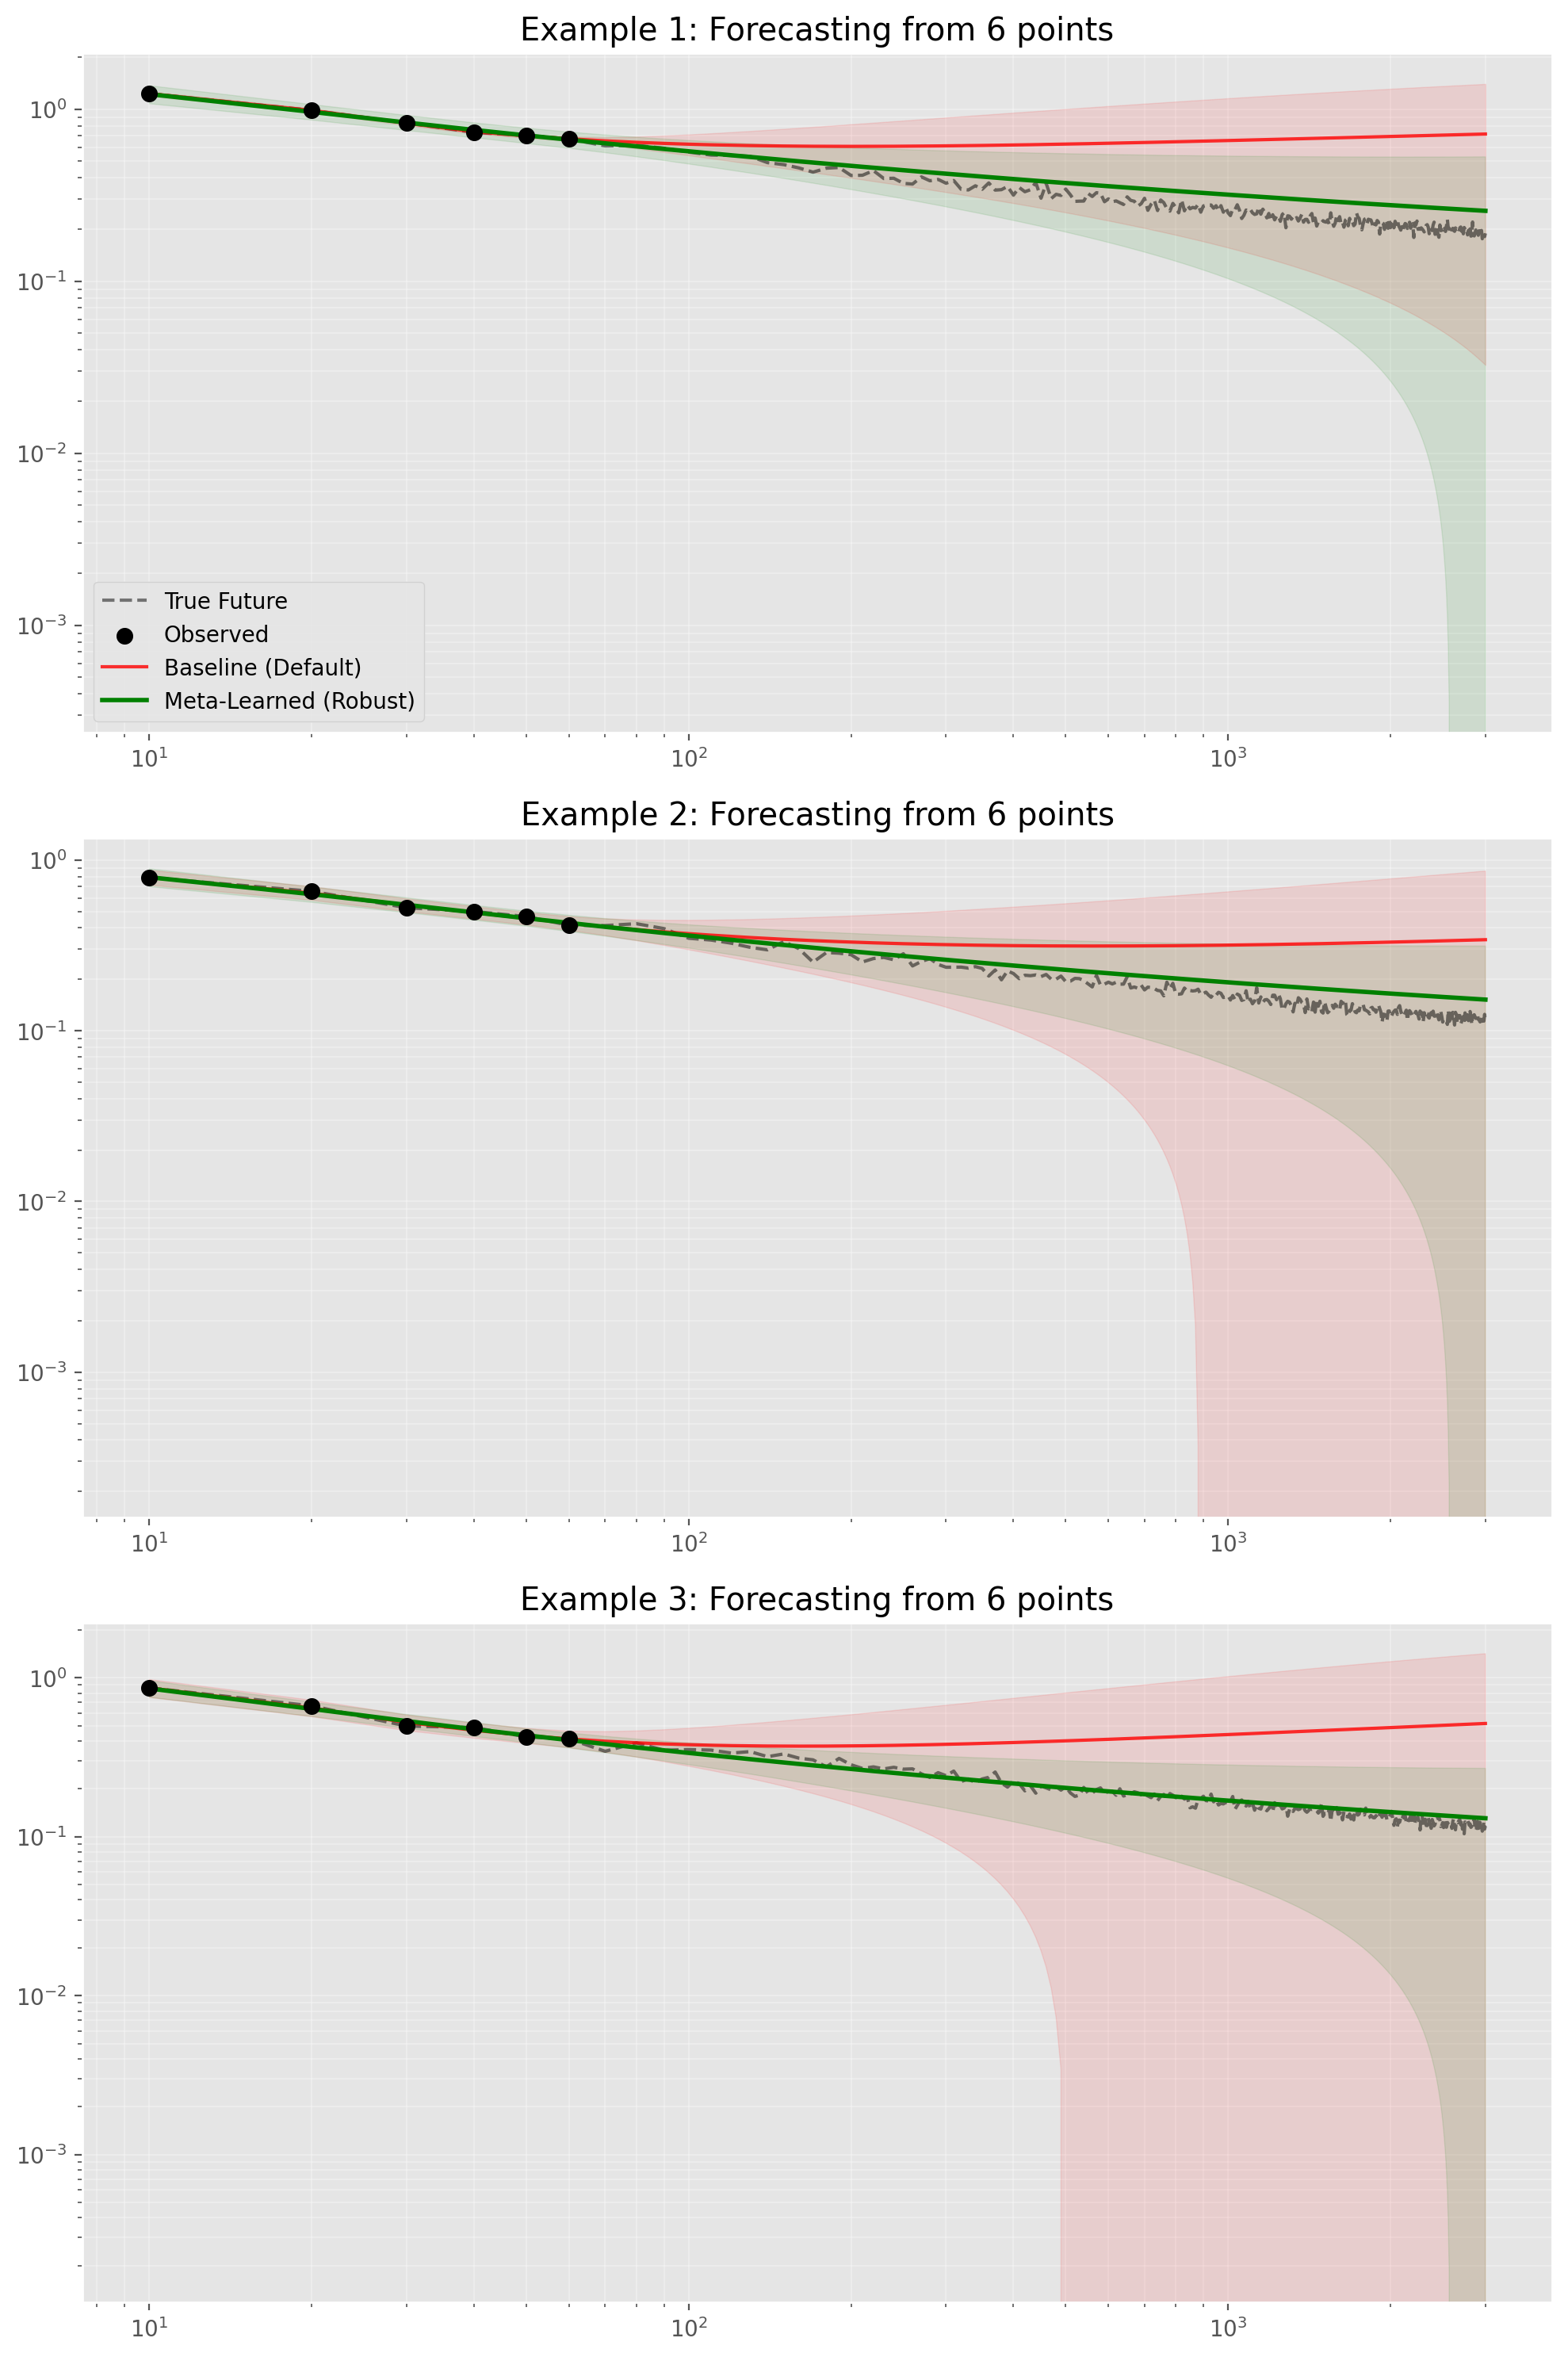

In [6]:
# Run and visualize for a few random examples
fig, axes = plt.subplots(N_FORECAST_SAMPLES, 1, figsize=(10, 5 * N_FORECAST_SAMPLES))
if N_FORECAST_SAMPLES == 1: axes = [axes]

for i, ax in enumerate(axes):
    obs_steps, obs_losses, true_losses, p_base, s_base, p_meta, s_meta = run_comparison(OBSERVATION_COUNT)
    
    # Plot Truth
    ax.plot(FUTURE_STEPS, true_losses, 'k--', label='True Future', alpha=0.5)
    ax.scatter(obs_steps, obs_losses, c='k', s=50, zorder=5, label='Observed')
    
    # Plot Baseline
    ax.plot(FUTURE_STEPS, p_base, 'r', alpha=0.8, label='Baseline (Default)')
    ax.fill_between(FUTURE_STEPS, p_base - 1.96*s_base, p_base + 1.96*s_base, color='r', alpha=0.1)
    
    # Plot Meta
    ax.plot(FUTURE_STEPS, p_meta, 'g', lw=2, label='Meta-Learned (Robust)')
    ax.fill_between(FUTURE_STEPS, p_meta - 1.96*s_meta, p_meta + 1.96*s_meta, color='g', alpha=0.1)
    
    ax.set_title(f"Example {i+1}: Forecasting from {OBSERVATION_COUNT} points")
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.grid(True, which='both', alpha=0.3)
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()